# ASTR302 Lab 7: Astrometry and Calibrated Photometry

In this Lab you will determine the right ascension and declination of your sources and calibrate the photometry

## Where are we?

You probably pointed the telescope at this field, or at least someone did. So you would think we would know the coordinates. However, in general the telescope pointing is not succiently precise to serve our purposes. We want to do better. 

Before we start, lets import the packages you will be needing for this Lab. You'll be using the astrometry solver which is based on the astronomy.net algorithm. 

In [2]:
#lets install the astrometry package (from astronomy.net)
!pip install --upgrade pip
!pip install astrometry

import matplotlib.pyplot as plt
import csv
import astrometry
import pandas as pd
import astropy.units as u
import numpy as np

import astropy as ap
from astropy.wcs import WCS
from astropy.io import fits

# the 'scales' in the following need to be chosen match to the estimated field-of-view (see https://pypi.org/project/astrometry/)
# these scales are the ones for the image you are working with

solver = astrometry.Solver(
    astrometry.series_5200.index_files(
        cache_directory="astrometry_cache",
        scales={1,3},
    )
)

This next cell just reads in your photometry file from before and gets the list of stars that will be used by the astrometry solver.

In [3]:
# read the CSV file and make a list of coordinate pairs for astronometry solver
import re
catalog = pd.read_csv(r'/workspaces/astr302/new_photometry.csv')

unit = "pix"
x = [str(sub).replace(unit, "").strip() for sub in catalog['xcenter']]
y = [str(sub).replace(unit, "").strip() for sub in catalog['ycenter']]

stars = [(x[i],y[i]) for i in range(0,len(x))]
print(stars)

[('1063.1711772657966', '70.73517360537362'), ('1286.0248138879692', '169.83559205702886'), ('1926.7490458557636', '183.5113186766256'), ('626.1909411826289', '202.5953274580391'), ('1404.2273464072791', '234.50698987821053'), ('1006.455431480202', '347.68055647463615'), ('1524.1336981624847', '373.9334142192574'), ('1730.7012719317656', '397.1906521187585'), ('1869.5280562216224', '471.6751010512597'), ('1635.1768287624216', '503.40350333035104'), ('708.9461636337188', '615.4714155067529'), ('1551.03423242148', '660.4787145055359'), ('449.6863412445824', '674.42803880774'), ('323.34835352149804', '799.9832827901635'), ('1442.8815621824606', '824.9689380393313'), ('1267.112511232739', '1004.467209696376'), ('918.3504489506342', '1166.8567280355878'), ('950.0322302558076', '1285.1413598739312'), ('1874.9604858074747', '1319.8804361187058'), ('236.2849419711685', '1346.9922536583138'), ('1193.938520407029', '1372.0765798943223')]


Now on to the actual solver. At the end we print out the header coordinates and the solved coordinates for comparison.

In [5]:
filename = r'/workspaces/astr302/save.fits'
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header

import astrometry
import logging

logging.getLogger().setLevel(logging.INFO)

print(stars)
# start with values close to the what is given in the header
solution = solver.solve(
    stars=stars,
    size_hint=None,
    position_hint=astrometry.PositionHint(
        ra_deg=346.2,
        dec_deg=-8.68,
        radius_deg=1.0),
    solution_parameters=astrometry.SolutionParameters(),
)    

# defines new wcs reference frame using solved for values



INFO:root:solve 1: start
INFO:root:solve 1: slice=[0, 25) (1 / 1), index="5200/index-5201-17.fits" (1 / 2)


[(np.float64(89.92928712916824), np.float64(35.45551141862407)), (np.float64(1063.1711772657966), np.float64(70.73517360537362)), (np.float64(1286.0248138879692), np.float64(169.83559205702886)), (np.float64(1926.7490458557636), np.float64(183.5113186766256)), (np.float64(2021.079258939168), np.float64(183.6731358231472)), (np.float64(626.1909411826289), np.float64(202.5953274580391)), (np.float64(617.6150482355243), np.float64(203.9073259042073)), (np.float64(1404.2273464072791), np.float64(234.50698987821053)), (np.float64(1382.5845056876562), np.float64(253.2209577380829)), (np.float64(423.9988318422993), np.float64(345.6389652647967)), (np.float64(1006.455431480202), np.float64(347.68055647463615)), (np.float64(1524.1336981624847), np.float64(373.9334142192574)), (np.float64(1730.7012719317656), np.float64(397.1906521187585)), (np.float64(1869.5280562216224), np.float64(471.6751010512597)), (np.float64(1635.1768287624216), np.float64(503.40350333035104)), (np.float64(1643.123297653

INFO:root:solve 1: logodds=86.6545, matches=10, conflicts=0, distractors=16, ra=346.224, dec=-8.68048, scale=0.110384, index="5200/index-5201-17.fits"
INFO:root:solve 1: slice=[0, 25) (1 / 1), index="5200/index-5203-17.fits" (2 / 2)


In [6]:
if solution.has_match():
    wcs = solution.best_match().astropy_wcs()
    
# it there is a good solution check out correspondence with previous values
    print('The header RA is ',hdr['RA-D'],'and the solved RA is ',solution.best_match().center_ra_deg)
    print('The header Dec is ',hdr['DEC-D'],'and the solved Dec is ',solution.best_match().center_dec_deg)
    print('The header plate scale is ',hdr['SCALE'],'and the solved plate scale is ',solution.best_match().scale_arcsec_per_pixel)

The header RA is  346.2275417 and the solved RA is  346.22373327671863
The header Dec is  -8.7885556 and the solved Dec is  -8.680482449513045
The header plate scale is  0.111 and the solved plate scale is  0.1103842193217599


Now we will display the image, with the new coordinates, and proceed to list the coordinates of your stars. The way we will calibrate the photometry is by comparing the instrumental magnitudes you have measured for your stars with the available Sloan Digital Sky Survey values available through the Legacy Viewer (https://www.legacysurvey.org/viewer/). To keep this relatively simple, we'll do this by hand. Note that the way the image is displayed here is flipped relative to how the Viewer shows the field. You will also need to adjust the vmin and vmax values to get the best image display.

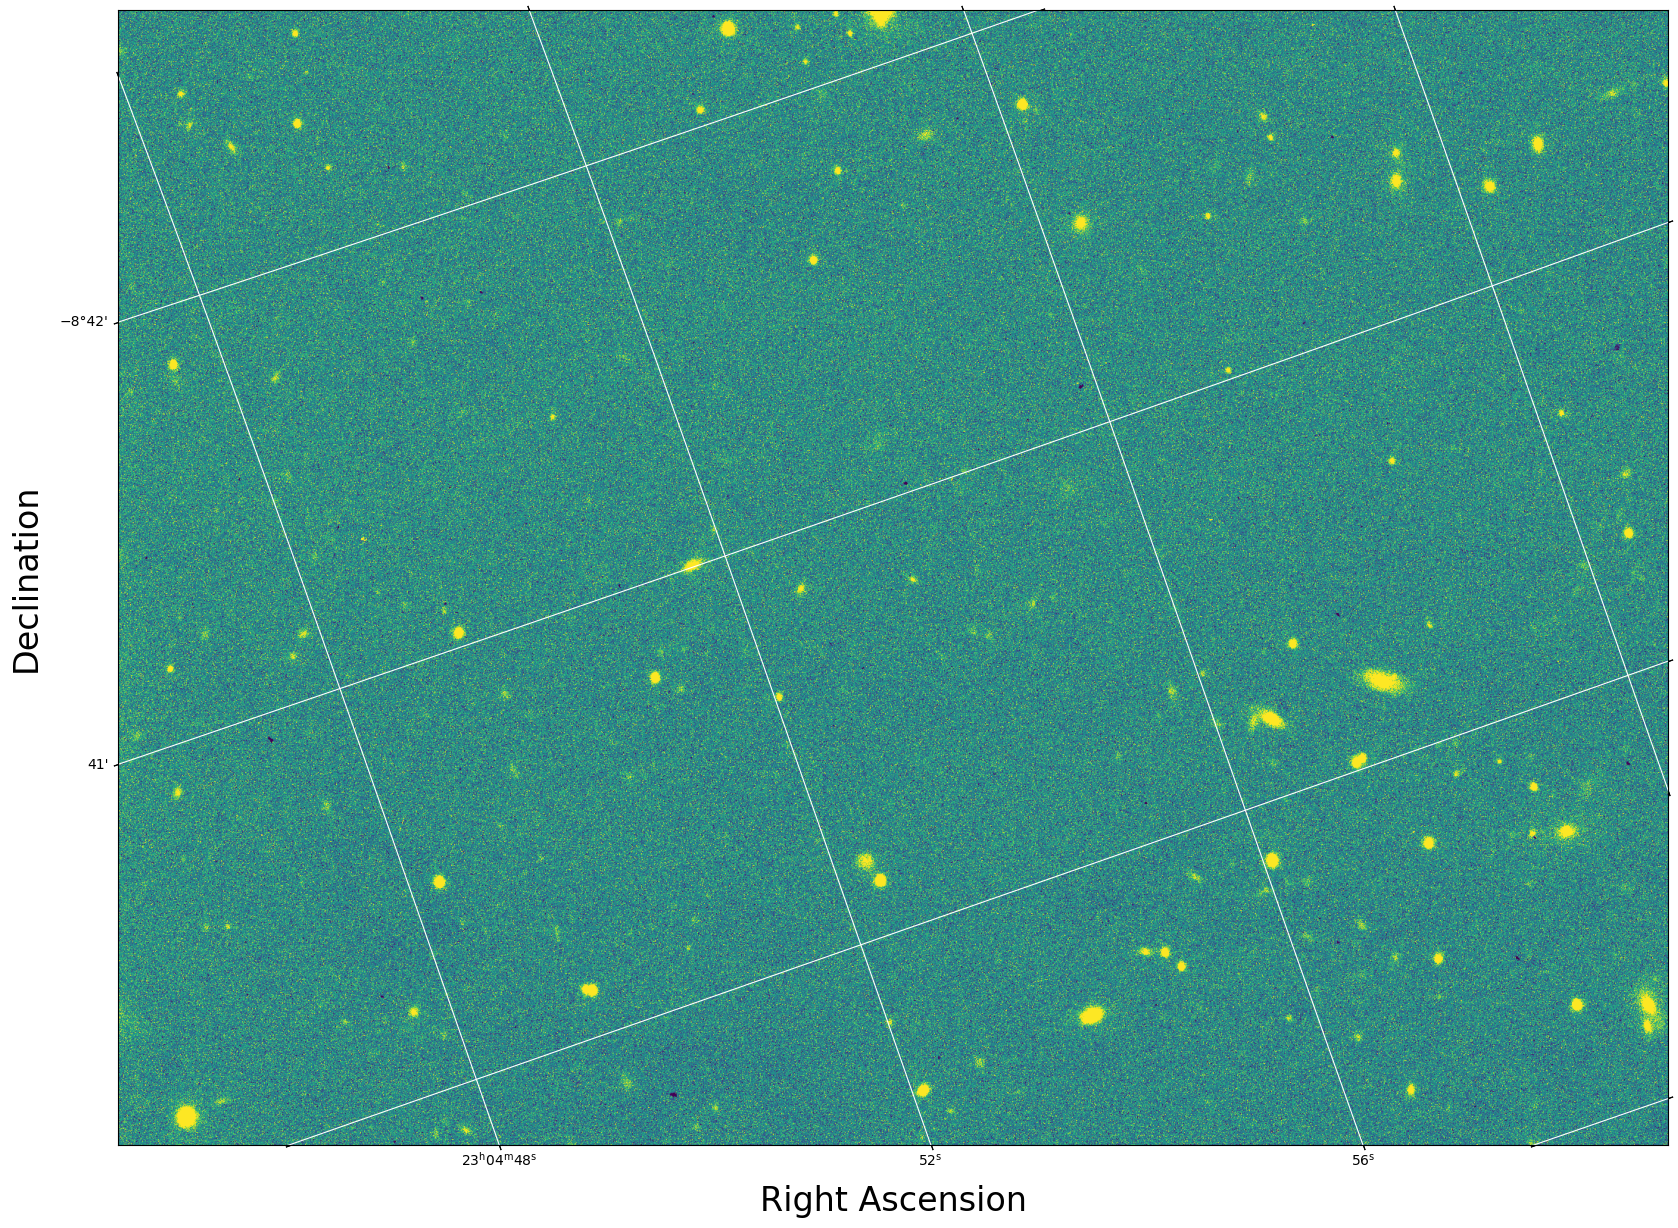

In [7]:
# define the image, open, and read the header information - use your reduced image from the previous workbook
mean = np.mean(image)
std = np.std(image)

# Create the plotting object with the WCS projection.
plt.figure(figsize = (20,20))
plt.subplot(projection=wcs)
plt.imshow(image, vmin=mean-std, vmax=mean+std)
plt.grid(color='white', ls='solid', alpha=1)
plt.xlabel('Right Ascension',fontsize=24)
plt.ylabel('Declination',fontsize=24)

In [14]:
# print out the coordinates of the stars that were used for the coordinate solution
if solution.has_match():
    for star in solution.best_match().stars:
        print(f"{star.ra_deg}, {star.dec_deg}:")
        
if solution.has_match():
    wcs = solution.best_match().astropy_wcs()
    pixels = wcs.all_world2pix(
        [[star.ra_deg, star.dec_deg] for star in solution.best_match().stars],
        0,
    )
# pixels is a len(solution.best_match().stars) x 2 numpy array of float values    
print(pixels)

346.2336726615787, -8.66433147357102:
346.18823480952403, -8.66905617739931:
346.243513265095, -8.65474112509978:
346.23425808030146, -8.69655549376907:
346.2123013150077, -8.679577461529542:
346.20119195980266, -8.674652824543134:
346.23997872258013, -8.662921007300673:
346.2382475076029, -8.666945959064282:
346.2056692768748, -8.668461831367345:
346.22407622412464, -8.693401828060251:
346.21709250099656, -8.660225315520053:
346.22830047538, -8.662268106409043:
346.20532448308535, -8.683843772781202:
[[1523.06171152  372.81730261]
 [  88.99873938   34.44605851]
 [1925.73579237  182.40134077]
 [1193.02714484 1371.05485057]
 [ 708.11663795  614.64352123]
 [ 422.48273162  344.94719115]
 [1729.86563102  396.668031  ]
 [1634.02488493  502.10075785]
 [ 625.47522792  201.23509853]
 [ 917.17552805 1165.90174119]
 [1062.04847644   69.91748412]
 [1381.71259914  252.12536068]
 [ 448.90565533  673.20804346]]


You have a choice here. You can just use the Legacy Viewer and the coordinates of these stars to get the SDSS magnitudes (use r band, but also keep the g band as we will want to look at the dependence of the calibration vs. color) to build up your photometric calibration or you can use astroquery (https://iopscience.iop.org/article/10.3847/1538-3881/aafc33) to get the magnitudes from the SIMBAD database. The latter will likely require much more effort, but will be more general if you want to make it so.

<div class="alert alert-info"> Make a plot of instrumental magnitude vs. SDSS magnitude for these stars. Perform a linear fit to get the zero point (the offset) and check for linearity. </div>

Zero point is -19.82273653282474


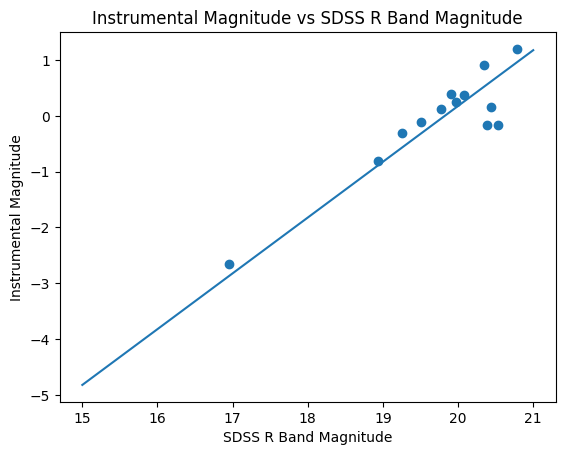

In [18]:
import scipy
from scipy.optimize import curve_fit

r_mags = np.array([18.94, 16.95, 19.5, 19.77, 19.91, 19.26, 19.97, 20.38, 20.53, 20.79, 20.08, 20.35, 20.44])
g_mags = np.array([20.2, 17.65, 20.22, 20.55, 20.19, 20.3, 20.46, 21.76, 21.65, 21.45, 21.25, 20.8, 21.59])

flux = []
flux.append(catalog['aperture_sum_5'][11])
flux.append(catalog['aperture_sum_5'][0])
flux.append(catalog['aperture_sum_5'][3])
flux.append(catalog['aperture_sum_5'][29])
flux.append(catalog['aperture_sum_5'][16])
flux.append(catalog['aperture_sum_5'][9])
flux.append(catalog['aperture_sum_5'][12])
flux.append(catalog['aperture_sum_5'][14])
flux.append(catalog['aperture_sum_5'][5])
flux.append(catalog['aperture_sum_5'][25])
flux.append(catalog['aperture_sum_5'][1])
flux.append(catalog['aperture_sum_5'][8])
flux.append(catalog['aperture_sum_5'][19])

mag = []
for i in range(len(flux)):
    mag.append(-2.5*np.log10(flux[i]/1e5))

plt.scatter(r_mags, mag)
plt.xlabel("SDSS R Band Magnitude")
plt.ylabel("Instrumental Magnitude")
plt.title("Instrumental Magnitude vs SDSS R Band Magnitude")

def linfit(x, b):
    return x + b

popt, pcov = curve_fit(linfit, r_mags, mag, 0)
x = np.arange(15, 22)
plt.plot(x, linfit(x, popt[0]))
print(f"Zero point is {popt[0]}")

<div class="alert alert-block alert-success">
Answer:
</div>

<div class="alert alert-info"> Now plot the offset from the fit for each star vs. color. Do you see a trend or just scatter. If there is a trend, describe the possible origin and how to address it in the calibration.</div>

Slope:-0.7748870359227752


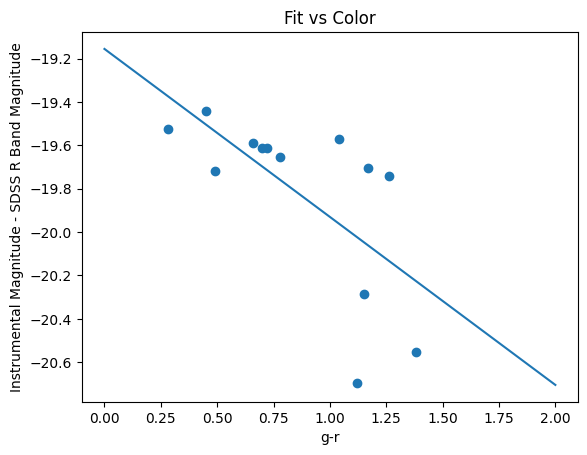

In [24]:
plt.scatter(g_mags - r_mags, mag - r_mags)
plt.xlabel("g-r")
plt.ylabel("Instrumental Magnitude - SDSS R Band Magnitude")
plt.title("Fit vs Color")

def linfit2(x, a, b):
    return a*x - b

p0 = 0,0
popt, pcov = curve_fit(linfit2, g_mags - r_mags, mag - r_mags, p0)
x = np.arange(0, 3)
plt.plot(x, linfit2(x, popt[0], popt[1]))
print(f'Slope:{popt[0]}')

<div class="alert alert-block alert-success">
Answer: Not seeing a super clear trend, there seems to be gradual decrease in magnitude as color increases but nothing concrete. Some outliers so the line of best fit isn't super accurate.
</div>

## Conclusion: 

 <div class="alert alert-info">Save your notebook.  Append your LastNameFirstInitial to the filename and submit via D2L </div>